In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.formula.api import ols
import researchpy as rp
import os

In [224]:
location = '../../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation'
promoter_pref='promoters_5UTR'
file_names='non-overlapping_includingbidirectional_all_genes_newannotation'
Czechowski_gene_categories = f'../../../data/output/{file_names}/genes/{promoter_pref}_czechowski_constitutive_variable_random.txt'

In [6]:
#make directory for the plots to be exported to
dirName = f'{location}/rolling_window/TFBS_coverage_rw/plots'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation/rolling_window/TFBS_coverage_rw/plots  created


In [133]:
#bp_covered = '../../data/promoter_analysis/promoters.bp_covered.txt'
bp_covered = f'{location}/rolling_window/TFBS_coverage_rw/{promoter_pref}_bpcovered_rw.bed'
promoter_bed = f'{location}/FIMO/{promoter_pref}.bed'

In [206]:
#read in coverage bedfile
coverage_df = pd.read_table(bp_covered, sep='\t', header=None)
col = ['chr','start','stop','name','no._of_overlaps', 'no._of_bases_covered','window_length','fraction_bases_covered']
coverage_df.columns = col
#add % bases covered column
coverage_df['percentage_bases_covered'] = coverage_df.fraction_bases_covered * 100

In [207]:
coverage_df

,chr,start,stop,name,no._of_overlaps,no._of_bases_covered,window_length,fraction_bases_covered,percentage_bases_covered
0,1,2630,2730,AT1G01010_1,0,0,100,0.00,0.0
1,1,2680,2780,AT1G01010_2,0,0,100,0.00,0.0
2,1,2730,2830,AT1G01010_3,0,0,100,0.00,0.0
3,1,2780,2880,AT1G01010_4,0,0,100,0.00,0.0
4,1,2830,2930,AT1G01010_5,0,0,100,0.00,0.0
...,...,...,...,...,...,...,...,...,...
363248,5,26971368,26971468,AT5G67640_5,0,0,100,0.00,0.0
363249,5,26971418,26971518,AT5G67640_4,0,0,100,0.00,0.0
363250,5,26971468,26971568,AT5G67640_3,2,24,100,0.24,24.0
363251,5,26971518,26971618,AT5G67640_2,2,24,100,0.24,24.0


In [198]:
#allow colour codes in seaborn
sns.set(color_codes=True)
sns.set_style("whitegrid")

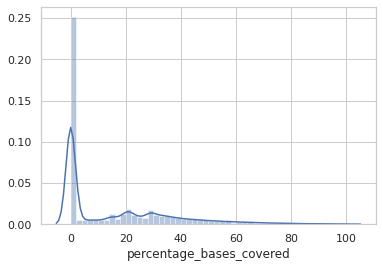

In [208]:
dist_plot = coverage_df['percentage_bases_covered']
#create figure with no transparency
dist_plot_fig = sns.distplot(dist_plot).get_figure()

#save to file
#dist_plot_fig.savefig(f'{location}/TFBS_coverage/plots/bp_covered_dist.pdf', format='pdf')


In [209]:
#Add AGI and window_number column to coverage_df
coverage_df = coverage_df.assign(AGI=coverage_df.name.str.extract(r'(.*?)\_'))
coverage_df['window_number'] = coverage_df.name.str.split('_', n=2, expand = True)[1]
#coverage_df = coverage_df.assign(window_number=coverage_df.name.str[-1:])
coverage_df


,chr,start,stop,name,no._of_overlaps,no._of_bases_covered,window_length,fraction_bases_covered,percentage_bases_covered,AGI,window_number
0,1,2630,2730,AT1G01010_1,0,0,100,0.00,0.0,AT1G01010,1
1,1,2680,2780,AT1G01010_2,0,0,100,0.00,0.0,AT1G01010,2
2,1,2730,2830,AT1G01010_3,0,0,100,0.00,0.0,AT1G01010,3
3,1,2780,2880,AT1G01010_4,0,0,100,0.00,0.0,AT1G01010,4
4,1,2830,2930,AT1G01010_5,0,0,100,0.00,0.0,AT1G01010,5
...,...,...,...,...,...,...,...,...,...,...,...
363248,5,26971368,26971468,AT5G67640_5,0,0,100,0.00,0.0,AT5G67640,5
363249,5,26971418,26971518,AT5G67640_4,0,0,100,0.00,0.0,AT5G67640,4
363250,5,26971468,26971568,AT5G67640_3,2,24,100,0.24,24.0,AT5G67640,3
363251,5,26971518,26971618,AT5G67640_2,2,24,100,0.24,24.0,AT5G67640,2


In [87]:
#calculate mean of each window number
def window_means(df,column):
    """function to calculate means of a column for each window number in a df"""
    groupby_window = df.groupby('window_number')
    #output = DataFrame()
    d = []
    for type, value in groupby_window['percentage_bases_covered']:
        d.append({'window':type, 'mean_TFBScoverage':value.mean()})
    output = pd.DataFrame(d)
    #sort by window no.
    output = output.astype({'window': 'int64'})
    output.sort_values(['window'], inplace=True, ignore_index=True)
    return output
    #need to make a df with means of %bpcovered for each window number
    #Then make a graph see https://edinburgh-genome-foundry.github.io/DnaFeaturesViewer/examples/with_gc_plot.html
    

In [125]:
# def window_plot(coverage_df, ax):
#     """function to plot the window for the length of the windows"""
#     y=coverage_df.percentage_bases_covered
#     x=coverage_df.window_number
    
#     #no_of_windows = int(len(coverage_df.window_number.unique()))
#    # xx = np.arange((no_of_windows * (window_length-window_offset)) - window_length) + window_offset
    

    

In [235]:
def windows_coords(promoter_bed,coverage_df):
    """function to add the centre of each window corresponding to each window no."""
    #read in bed file
    promoter_df = pd.read_table(promoter_bed, sep='\t', header=None)
    col = ['chr','start','stop','AGI','dot1', 'strand','source','type','dot2','attributes']
    promoter_df.columns = col
    #add promoter length column
    promoter_df['length'] = promoter_df.stop-promoter_df.start
    #merge promoter_bed with overeage_df on AGI
    merged = pd.merge(coverage_df, promoter_df, on='AGI',  how='left',suffixes=('','_wholeprom')) 
    #calculate longest promoter length
    length_of_longest_promoter = merged.length.max()
    #split merged into 2 dfs by strand
    pos = merged[merged.strand == '+'].copy()
    neg = merged[merged.strand == '-'].copy()
    
    #add coverage position column where position is the middle of the window, with whole length of the longest promoter
    pos['position'] = (pos.start+0.5*(pos.stop-pos.start)) - pos.start_wholeprom
    neg['position'] = (neg.stop_wholeprom) - (neg.start+0.5*(neg.stop-neg.start))
    merged2 = pd.merge(pos,neg,how='outer')

    merged2 = merged2.astype({'position': 'int64'})

    #lineplot
    sns.lineplot(y=merged2.percentage_bases_covered, x=merged2.position)
    plt.xlim(length_of_longest_promoter, 0)
    
    
    return merged2

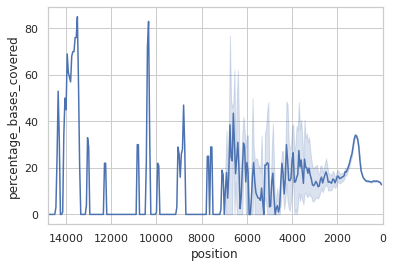

In [236]:
#all promoters in genome
merged = windows_coords(promoter_bed,coverage_df)

## Now do constitutive and variable promoter from Czechowski et al 2005

In [225]:
def add_genetype(coverage,gene_categories):
    """function to add gene type to the df, and remove random genes"""
    select_genes = pd.read_table(gene_categories, sep='\t', header=None)
    cols = ['AGI', 'gene_type']
    select_genes.columns = cols

    merged = pd.merge(select_genes, coverage, on='AGI', how='left')   
   # no_random = merged_renamed[merged_renamed.gene_type != 'random']
  #  no_random.reset_index(drop=True, inplace=True)
    
    return merged

In [232]:
coverage_prom_types = add_genetype(coverage_df, Czechowski_gene_categories)

In [233]:
coverage_prom_types

,AGI,gene_type,chr,start,stop,name,no._of_overlaps,no._of_bases_covered,window_length,fraction_bases_covered,percentage_bases_covered,window_number
0,AT1G01060,constitutive,1,37093,37193,AT1G01060_26,0,0,100,0.00,0.0,26
1,AT1G01060,constitutive,1,37143,37243,AT1G01060_25,1,24,100,0.24,24.0,25
2,AT1G01060,constitutive,1,37193,37293,AT1G01060_24,1,24,100,0.24,24.0,24
3,AT1G01060,constitutive,1,37243,37343,AT1G01060_23,0,0,100,0.00,0.0,23
4,AT1G01060,constitutive,1,37293,37393,AT1G01060_22,9,23,100,0.23,23.0,22
...,...,...,...,...,...,...,...,...,...,...,...,...
5301,AT2G40120,control,2,16758299,16758399,AT2G40120_5,2,21,100,0.21,21.0,5
5302,AT2G40120,control,2,16758349,16758449,AT2G40120_4,2,7,100,0.07,7.0,4
5303,AT2G40120,control,2,16758399,16758499,AT2G40120_3,4,20,100,0.20,20.0,3
5304,AT2G40120,control,2,16758449,16758549,AT2G40120_2,4,37,100,0.37,37.0,2


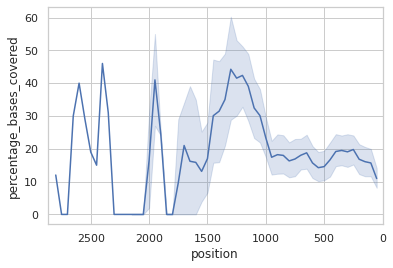

In [237]:
constitutive_rolling = windows_coords(promoter_bed,coverage_prom_types[coverage_prom_types.gene_type == 'constitutive'])

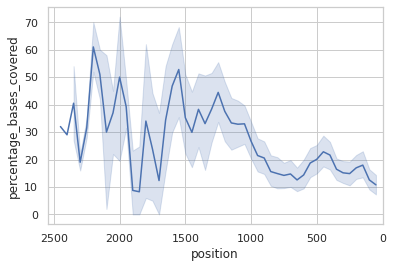

In [238]:
variable_rolling = windows_coords(promoter_bed,coverage_prom_types[coverage_prom_types.gene_type == 'variable'])

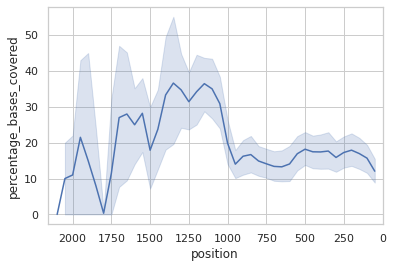

In [239]:
random_rolling = windows_coords(promoter_bed,coverage_prom_types[coverage_prom_types.gene_type == 'control'])